In [25]:
"""" Imports """
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras._tf_keras.keras.optimizers import Adam

In [26]:
# Pad naar de dataset
os.chdir('C:/Users/nakas/OneDrive/Documents/stat/casus/CasusD/data')
data_dir = "patients"

# Functie om de dataset in te laden
def load_data(data_dir):
    """
    Loads the data and preproces data
    :param data_dir: data directory
    :return df: pandas dataframe containing;
    patient id, label, x (coords), y (coords) and image filepath

    """
    data = []
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        if os.path.isdir(patient_path):
            for label in ['0', '1']:
                label_dir = os.path.join(patient_path, label)
                for file in os.listdir(label_dir):
                    if file.endswith('.png'):
                        file_path = os.path.join(label_dir, file)
                        # Verwijder 'x'
                        x = file.split('_')[2].replace('x', '')
                        # Verwijder 'y'
                        y = file.split('_')[3].replace('y', '')
                        img = Image.open(file_path)
                        if np.asarray(img).shape == (50,50,3):
                            data.append({
                                'patient': patient_dir,
                                'label': int(label),
                                'x': int(x),
                                'y': int(y),
                                'file_path': file_path
                            })
    return pd.DataFrame(data)

# Data inladen
df = load_data(data_dir)
print(f"Data geladen: {len(df)} rijen")
print(df.head())

# Controleer op missende waarden
missing_values = df.isnull().sum()
print("Missende waarden per kolom:")
print(missing_values)


Data geladen: 275222 rijen
  patient  label     x     y  \
0   10253      0  1001  1001   
1   10253      0  1001  1051   
2   10253      0  1001  1101   
3   10253      0  1001  1151   
4   10253      0  1001  1201   

                                           file_path  
0  patients\10253\0\10253_idx5_x1001_y1001_class0...  
1  patients\10253\0\10253_idx5_x1001_y1051_class0...  
2  patients\10253\0\10253_idx5_x1001_y1101_class0...  
3  patients\10253\0\10253_idx5_x1001_y1151_class0...  
4  patients\10253\0\10253_idx5_x1001_y1201_class0...  
Missende waarden per kolom:
patient      0
label        0
x            0
y            0
file_path    0
dtype: int64


In deze dataset zijn er geen missende waarden. In dit geval kan je zeggen dat er geen uitsneden uit de totale afbeelding ontbreken.

Uitsneden per klasse:
label
0    196454
1     78768
Name: count, dtype: int64
Verhouding tussen klassen:
label
0    71.380195
1    28.619805
Name: count, dtype: float64
         Gezond (%)  Ongezond (%)
patient                          
10253     87.249545     12.750455
10254     91.037736      8.962264
10255     66.544118     33.455882
10256     75.000000     25.000000
10257     67.244094     32.755906


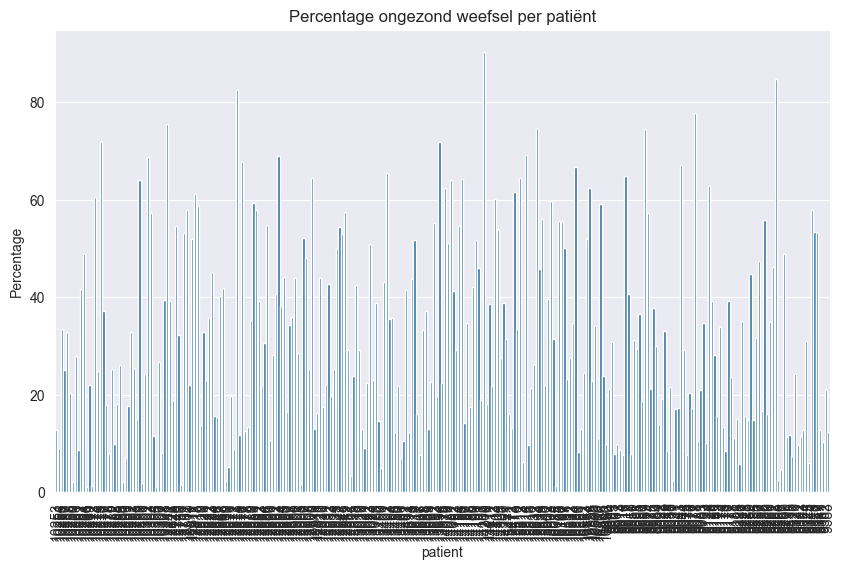

In [27]:
# Aantal uitsneden per klasse
counts = df['label'].value_counts()
print(f"Uitsneden per klasse:\n{counts}")

# Verhouding tussen gezond en ongezond weefsel
total = len(df)
percentages = counts / total * 100
print(f"Verhouding tussen klassen:\n{percentages}")

# Percentage ongezond weefsel per patiënt
patient_stats = df.groupby('patient')['label'].value_counts(normalize=True).unstack().fillna(0)
patient_stats.columns = ['Gezond (%)', 'Ongezond (%)']
patient_stats *= 100
print(patient_stats.head())

# Visualisatie van ongezond weefsel per patiënt
plt.figure(figsize=(10, 6))
sns.barplot(x=patient_stats.index, y=patient_stats['Ongezond (%)'])
plt.xticks(rotation=90)
plt.title("Percentage ongezond weefsel per patiënt")
plt.ylabel("Percentage")
plt.show()


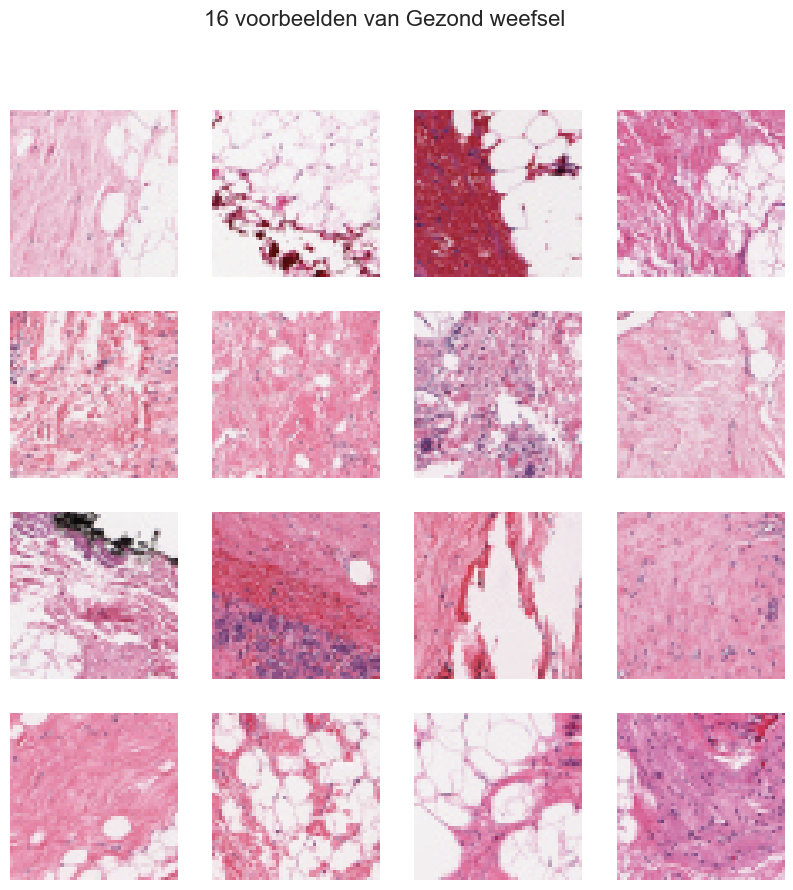

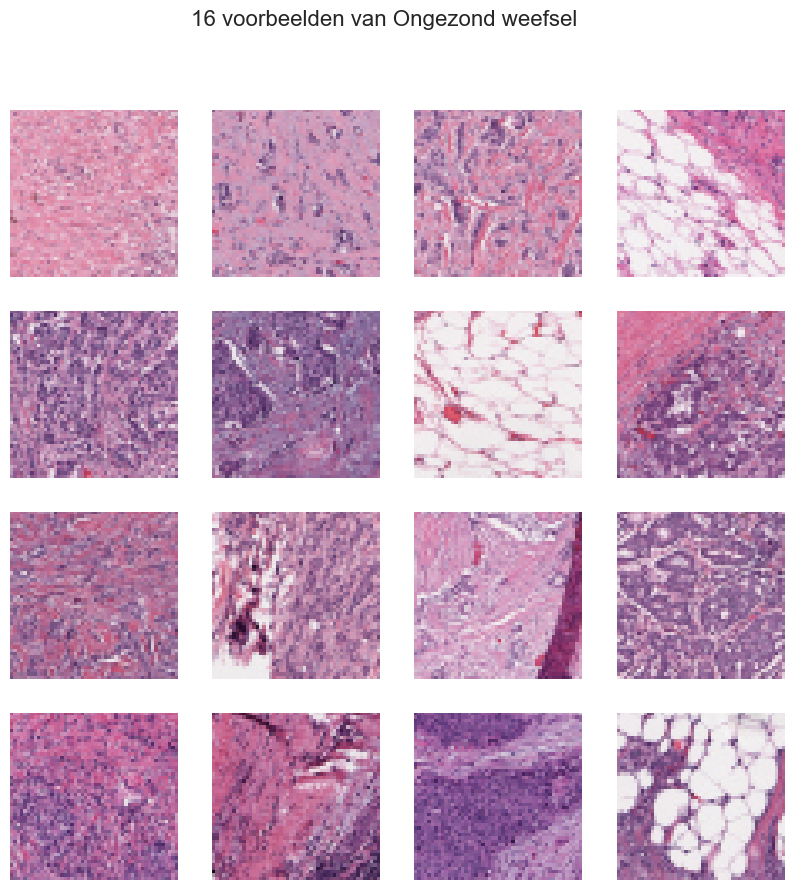

In [28]:
# Functie om afbeeldingen te tonen
def plot_samples(df, label, n=16):
    """
    Visualize samples dataset
    :param df: pandas dataframe
    :param label: label
    :param n: number of samples
    :return fig: matplotlib figure
    """
    samples = df[df['label'] == label].sample(n)
    plt.figure(figsize=(10, 10))
    for i, file_path in enumerate(samples['file_path']):
        plt.subplot(4, 4, i + 1)
        img = Image.open(file_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"{n} voorbeelden van {'Ongezond' if label == 1 else 'Gezond'} weefsel",
                 fontsize=16)
    plt.show()

# Toon voorbeelden
plot_samples(df, label=0, n=16)  # Gezond
plot_samples(df, label=1, n=16)  # Ongezond

In [29]:
# Functie om een subset van de data te nemen
def sample_data(df, fraction=0.1):
    """
    Make a sample data
    :param df: pandas dataframe
          fraction: fraction of samples
    :return data: pandas dataframe
    """
    return df.sample(frac=fraction, random_state=42)

# Neem slechts 10% van de data
df_sampled = sample_data(df, fraction=0.1)

# Functie om horizontaal te splitsen
def split_data_horizontal(df):
    """
    Split data horizontally
    :param df: pandas dataframe
    :return train dataframe, test dataframe
    """
    patients = df['patient'].unique()
    train_patients, test_patients = train_test_split(patients,
                                                     test_size=0.2,
                                                     random_state=42)
    train_df = df[df['patient'].isin(train_patients)]
    test_df = df[df['patient'].isin(test_patients)]
    return train_df, test_df

# Data splitsen
train_df, test_df = split_data_horizontal(df_sampled)

# Functie om data en labels te laden
def load_images(df):
    """
    Load data and create image and label
    :param df: pandas dataframe
    :return image array and label array
    """
    images = []
    labels = []
    for _, row in df.iterrows():
        img = Image.open(row['file_path'])
        images.append(np.array(img) / 255.0)  # Normaliseer
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Laad trainings- en testdata
x_train, y_train = load_images(train_df)
x_test, y_test = load_images(test_df)

# Labels naar one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [30]:

# 1. Data inladen
data_dir = "patients"
patients = os.listdir(data_dir)

# 2. 1% van de data eruit halen
df = sample_data(df, fraction=0.01)

# 3. Filter patiënten met minder dan 2 samples
patient_counts = df['patient'].value_counts()
valid_patients = patient_counts[patient_counts > 1].index
df_filtered = df[df['patient'].isin(valid_patients)]

# 4. Data splitsen in train en test data set
train_df, test_df = train_test_split(df_filtered,
                                     test_size=0.2,
                                     stratify=df_filtered['patient'],
                                     random_state=42)

# 5. Data voorbereiden
def prepare_data(df):
    """
    Create image and label from given data set
    :param df: pandas dataframe
    :return image array and label
    """
    images, labels = [], []
    for _, row in df.iterrows():
        img = Image.open(row['file_path'])
        images.append(np.array(img) / 255.0)  # Normaliseer
        labels.append(row['label'])
    return np.array(images), to_categorical(labels)

img_train, label_train = prepare_data(train_df)
img_test, label_test = prepare_data(test_df)

# 6. Model bouwen
model = Sequential([
    Conv2D(32, (3, 3),
           activation='relu',
           input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3),
           activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. Trainen
history = model.fit(img_train, label_train,
                    validation_data=(img_test, label_test),
                    epochs=10,
                    batch_size=32)

# 8. Evalueren
loss, accuracy = model.evaluate(img_test, label_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


C:\Users\nakas\OneDrive\Documents\stat\casus\CasusD\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6980 - loss: 0.6008 - val_accuracy: 0.7755 - val_loss: 0.4625
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7711 - loss: 0.4871 - val_accuracy: 0.7974 - val_loss: 0.5171
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7781 - loss: 0.4725 - val_accuracy: 0.8175 - val_loss: 0.4544
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7945 - loss: 0.4625 - val_accuracy: 0.8029 - val_loss: 0.4441
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7965 - loss: 0.4508 - val_accuracy: 0.8157 - val_loss: 0.4285
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8221 - loss: 0.4145 - val_accuracy: 0.7500 - val_loss: 0.4939
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7987 - loss: 0.4590 - val_accuracy: 0.8230 - val_loss: 0.4269
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8151 - loss: 0.4137 - val_accuracy: 0.8266 - v

In [31]:
def predict_image(image_path, model, class_names):
    """
    Predict the given image, if it is healthy or tumor tissue
    :param image_path
           model
           class_names: list of class names
    :return prediction"""
    # Load and preprocess the image
    img = Image.open(image_path)  # Open image file
    img_array = np.array(img) / 255.0  # Normalize
    # If grayscale, add channel dimension
    if len(img_array.shape) == 2:
        img_array = np.expand_dims(img_array, axis=-1)
        # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Output result
    print(f"Predicted class: {class_names[predicted_class]} "
          f"({prediction[0][predicted_class]:.2f} confidence)")

# Example usage
# Replace with the path to your image
image_path = "healthy.png"
# Replace with your actual class names
class_names = ["Healthy", "Unhealthy"]
predict_image(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted class: Healthy (1.00 confidence)
